<a href="https://www.kaggle.com/code/emanafi/lyricgen?scriptVersionId=221810361" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**LyricGen - An AI-Powered Lyric Completion Tool**

By Eman Sarah Afi

_Fall 2024_

# **1. Data Cleaning & Preprocessing:**

In [1]:
# Import necessary libraries
import os
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention, Layer
from tensorflow.keras.models import Model

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Load the dataset
dataset = pd.read_csv('/kaggle/input/genius-song-lyrics-with-language-information/song_lyrics.csv')

# Display the first 10 rows of the dataset
print(dataset.head(10))

# Display dataset info (columns, data-types, non-null counts)
print(dataset.info())

               title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   
5     Lollipop Remix  rap  Lil Wayne  2008  580832   
6         Im Not You  rap     Clipse  2002   28645   
7        Family Ties  rap    Cam'ron  2004   41960   
8  Rockin and Rollin  rap    Cam'ron  1998    6399   
9      Lord You Know  rap    Cam'ron  2004   11882   

                                       features  \
0                   {"Cam\\'ron","Opera Steve"}   
1                                            {}   
2                                            {}   
3  {"Cam\\'ron","Kanye West","Syleena Johnson"}   
4                                            {}   
5                 {"Kanye West","Static Major"}   
6   {Jadakiss,"Styles P","Roscoe P. Coldchain"} 

In [3]:
# Print the percentage of missing values per column
print(dataset.isnull().sum() / len(dataset) * 100)

title            0.003661
tag              0.000000
artist           0.000000
year             0.000000
views            0.000000
features         0.000000
lyrics           0.000000
id               0.000000
language_cld3    1.771539
language_ft      2.615886
language         4.419170
dtype: float64


In [4]:
# Define target languages (English, French, Arabic)
target_languages = ['en', 'fr', 'ar']

# Total rows in the dataset
total_rows = len(dataset)

# Calculate the percentage for each target language
percentages = {
    lang: (len(dataset[dataset['language'] == lang]) / total_rows) * 100
    for lang in target_languages
}

# Display the percentages
for lang, percentage in percentages.items():
    print(f"Percentage of rows with '{lang}': {percentage:.2f}%")

Percentage of rows with 'en': 65.71%
Percentage of rows with 'fr': 3.69%
Percentage of rows with 'ar': 0.19%


Naturally, considering that the intention is to work with three languages (English, French & Arabic), we have to filter the dataset to include the rows with these languages only. 

However, considering that the percentage of 'en' is extremely high, which could lead to performance issues on Kaggle, it is recommended to take a sample of rows that have 'en' as the language.

Other than that, the text is cleaned by removing punctuation, unique characters, and converting it to lowercase (except for Arabic). Plus, structural tags (e.g., [Chorus: ...]) will be removed to reduce the noise, and repeated lyrics were handled to prevent redundancy in tokenized sequences.

Finally, the dataset should only keep the columns it needs for this project, which in this case, the kept columns are 'language' and 'cleaned_lyrics'.

In [5]:
# Filter dataset using the 'language' column and create an explicit copy
filtered_dataset = dataset[dataset['language'].isin(target_languages)].copy()

# Function for cleaning multilingual lyrics (removes punctuation)
def clean_multilingual_lyrics_simple(lyric, lang):
    if pd.isnull(lyric):  # Handle missing lyrics
        return ""
    
    # Remove structural tags (e.g., [Chorus: Opera Steve & Cam'ron])
    lyric = re.sub(r"\[.*?\]", "", lyric)
    
    # Handle language-specific cleaning
    if lang == 'en':
        lyric = re.sub(r"[^a-zA-Z0-9\s]", "", lyric).lower()
    elif lang == 'fr':
        lyric = re.sub(r"[^a-zA-ZÀ-ÿ0-9\s]", "", lyric).lower()
    elif lang == 'ar':
        lyric = re.sub(r"[^\u0600-\u06FF0-9\s]", "", lyric)
    
    # Remove extra whitespace
    lyric = " ".join(lyric.split())
    return lyric

# Inspect group sizes
group_sizes = filtered_dataset['language'].value_counts()
print("Group sizes before sampling:", group_sizes)

# Set target sample size for each language
target_sample_size = 9000

# Sample data for each language
sampled_en = filtered_dataset[filtered_dataset['language'] == 'en'].sample(
    n=min(target_sample_size, len(filtered_dataset[filtered_dataset['language'] == 'en'])),
    random_state=42
)

sampled_fr = filtered_dataset[filtered_dataset['language'] == 'fr'].sample(
    n=min(target_sample_size, len(filtered_dataset[filtered_dataset['language'] == 'fr'])),
    random_state=42
)

sampled_ar = filtered_dataset[filtered_dataset['language'] == 'ar'].sample(
    n=min(target_sample_size, len(filtered_dataset[filtered_dataset['language'] == 'ar'])),
    random_state=42
)

# Combine all sampled data
sampled_dataset = pd.concat([sampled_en, sampled_fr, sampled_ar])

# Apply the cleaning function to the sampled dataset
sampled_dataset = sampled_dataset.assign(
    cleaned_lyrics=sampled_dataset.apply(
        lambda row: clean_multilingual_lyrics_simple(row['lyrics'], row['language']),
        axis=1
    )
)

# Keep only 'language' and 'cleaned_lyrics' columns
sampled_dataset = sampled_dataset[['language', 'cleaned_lyrics']]

# Display dataset summary
print(f"Final dataset columns: {sampled_dataset.columns.tolist()}")
print(f"Number of rows: {len(sampled_dataset)}")
print(sampled_dataset['language'].value_counts())
print(sampled_dataset.head())

Group sizes before sampling: language
en    3374198
fr     189436
ar       9889
Name: count, dtype: int64
Final dataset columns: ['language', 'cleaned_lyrics']
Number of rows: 27000
language
en    9000
fr    9000
ar    9000
Name: count, dtype: int64
        language                                     cleaned_lyrics
2645152       en  dont want to be along anymore dont want to hea...
1939177       en  africa rappers fuck you i dey greet so you guy...
969631        en  every time i kiss somebody new i make believe ...
4041818       en  i am the one who calls your name the day you l...
1976310       en  hella sketchy im always glistenin im always gl...


After the cleaning phase, it is preferred to check if there are any duplicated rows before proceeding with the embedding & tokenization phase. 

In [6]:
# Number of duplicated rows
num_duplicates = sampled_dataset.duplicated().sum()

# Percentage of duplicated rows
percentage_duplicates = (num_duplicates / len(sampled_dataset)) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

final_dataset = sampled_dataset.drop_duplicates()

# Number of duplicated rows
num_duplicates = final_dataset.duplicated().sum()

# Check for duplicated rows again
percentage_duplicates = (num_duplicates / len(final_dataset)) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

Percentage of duplicated rows: 0.27%
Percentage of duplicated rows: 0.00%


In [7]:
# Print the percentage of missing values per column
print(final_dataset.isnull().sum() / len(final_dataset) * 100)

language          0.0
cleaned_lyrics    0.0
dtype: float64


# **2. Embedding Preparation:**

The purpose of the embedding phase here is to transform text data into numerical representations suitable for Transformer-based models. 

To explain further:
- max_vocab_size will the vocabulary to the most frequent 50,000 words.
- max_sequence_length will set a fixed sequence length of 50 for uniform input size.

These values were chosen while taking into consideration the complexity of the multilingual and diverse nature of the Genius dataset

Then, tokenization is separately done for each language where the cleaned lyrics are into sequences of integers, and out-of-vocabulary words are replaced by a special token (<OOV>). After that, padding will ensure that the sequences have the same length for compatibility reasons.

And languages are encoded as integers (en: 0, fr: 1, ar: 2) for multi-language support.

In [8]:
# Define parameters
max_vocab_size = 50000  # Maximum number of words in each vocabulary
max_sequence_length = 50  # Maximum length of input sequences

sos_token = "<sos>"  # Define a start-of-sequence token
eos_token = "<eos>"  # Define an end-of-sequence token

# Prepare the text data
texts = final_dataset['cleaned_lyrics'].astype(str).tolist()
languages = final_dataset['language'].tolist()

# Create language-specific tokenizers
tokenizers = {
    'en': Tokenizer(num_words=max_vocab_size, oov_token="<OOV>"),
    'fr': Tokenizer(num_words=max_vocab_size, oov_token="<OOV>"),
    'ar': Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
}

# Separate texts by language
texts_by_language = {'en': [], 'fr': [], 'ar': []}
for text, lang in zip(texts, languages):
    texts_by_language[lang].append(f"{sos_token} {text} {eos_token}")  # Add <sos> and <eos> to each text

# Fit tokenizers on language-specific texts
for lang, lang_texts in texts_by_language.items():
    tokenizers[lang].fit_on_texts(lang_texts)
    tokenizers[lang].word_index[sos_token] = len(tokenizers[lang].word_index) + 1  # Ensure <sos> is part of vocabulary
    tokenizers[lang].word_index[eos_token] = len(tokenizers[lang].word_index) + 1  # Ensure <eos> is part of vocabulary

# Convert texts to sequences
X, y, lang_labels = [], [], []

for text, lang in zip(texts, languages):
    tokenizer = tokenizers[lang]
    seq = tokenizer.texts_to_sequences([f"{sos_token} {text} {eos_token}"])[0]
    for j in range(1, len(seq)):
        input_seq = seq[:j]
        target_seq = seq[j:j + max_sequence_length]
        if len(input_seq) <= max_sequence_length and len(target_seq) == max_sequence_length:
            X.append(input_seq)
            y.append(target_seq)
            lang_labels.append(lang)

# Pad sequences
X = pad_sequences(X, maxlen=max_sequence_length, padding='post', truncating='post')
y = pad_sequences(y, maxlen=max_sequence_length, padding='post', truncating='post')

# Convert language labels to numeric values
lang_map = {'en': 0, 'fr': 1, 'ar': 2}
lang_labels = np.array([lang_map[lang] for lang in lang_labels])

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp, lang_train, lang_temp = train_test_split(X, y, lang_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, lang_val, lang_test = train_test_split(X_temp, y_temp, lang_temp, test_size=0.5, random_state=42)

# Print summaries
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Print vocabulary sizes
for lang, tokenizer in tokenizers.items():
    print(f"{lang} Vocabulary size: {len(tokenizer.word_index)}")

# Example data
print(f"Example input sequence: {X_train[0]}")
print(f"Example target sequence: {y_train[0]}")
print(f"Example language label: {lang_train[0]}")

Total samples: 1293069
Training samples: 905148
Validation samples: 193960
Test samples: 193961
en Vocabulary size: 61545
fr Vocabulary size: 123407
ar Vocabulary size: 339608
Example input sequence: [   18     4   499 19182     6     5     1  1760   782     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
Example target sequence: [  105  1388     2  7436 17499     1    52 10194    40 41310 42755   179
 37430   179 11787     6    52 42756   499     1    30    20 15717   299
   118     2 33600 23335     4   379     2   800     1     4  1103 14590
   202    52 10900     1  1596  5426     6   621     3  1329     2  2389
     1  5797]
Example language label: 2


# **3. Output Readiness Check:**

This code segment will simply check if:
- The output shape is a 2D array for Transformer input.
- The sequences are of type int32 to ensure compatibility with embedding layers.
- Labels are included and match the number of sequences.

In [9]:
# Check input shape
print(f"Shape of input sequences (X): {X.shape}")
assert len(X.shape) == 2, "Input sequences (X) should be 2D (num_samples, max_sequence_length)."

# Check target shape
print(f"Shape of target sequences (y): {y.shape}")
assert len(y.shape) == 2, "Target sequences (y) should be 2D (num_samples, max_sequence_length)."

# Check language labels shape
print(f"Shape of language labels: {lang_labels.shape}")
assert len(lang_labels) == len(X), "Number of language labels must match the number of input sequences."

# Check data type of sequences
print(f"Data type of input sequences (X): {X.dtype}")
assert X.dtype == 'int32', "Input sequences (X) should be of type int32 for embedding layers."
print(f"Data type of target sequences (y): {y.dtype}")
assert y.dtype == 'int32', "Target sequences (y) should be of type int32 for embedding layers."

# Check label distribution (multilingual labels)
label_counts = Counter(lang_labels)
print(f"Language label distribution: {label_counts}")

# Validate vocabulary sizes for each language
for lang, tokenizer in tokenizers.items():
    vocab_size = len(tokenizer.word_index)
    print(f"{lang.upper()} Vocabulary size: {vocab_size}")
    # Ensure all tokens in sequences for this language are within the allowed vocabulary size
    lang_sequences = [X[i] for i in range(len(lang_labels)) if lang_labels[i] == lang_map[lang]]
    max_token = max([max(seq) for seq in lang_sequences if len(seq) > 0], default=0)
    assert max_token <= max_vocab_size, (
        f"{lang.upper()} token indices exceed max_vocab_size={max_vocab_size}."
    )
    print(f"{lang.upper()} vocabulary is correctly limited to the top {max_vocab_size} tokens.")

# Example input-output pair and label
print("Example input sequence (X[0]):", X[0])
print("Example target sequence (y[0]):", y[0])
print(f"Example language label: {lang_labels[0]}")

print("\nProcessed data is ready for Transformer model input.")

Shape of input sequences (X): (1293069, 50)
Shape of target sequences (y): (1293069, 50)
Shape of language labels: (1293069,)
Data type of input sequences (X): int32
Data type of target sequences (y): int32
Language label distribution: Counter({1: 436659, 2: 430252, 0: 426158})
EN Vocabulary size: 61545
EN vocabulary is correctly limited to the top 50000 tokens.
FR Vocabulary size: 123407
FR vocabulary is correctly limited to the top 50000 tokens.
AR Vocabulary size: 339608
AR vocabulary is correctly limited to the top 50000 tokens.
Example input sequence (X[0]): [48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Example target sequence (y[0]): [   24    64     5    23   517   577    24    64     5   205    16   452
   625    56     2   676   396    22    16  6488   146     6     3    29
  1611    12   201   424 12908    21     5  1529    61    25    11    24
   315   159   360    66 

# **4. Transformer Architecture:**

This code defines a custom TensorFlow layer called PositionalEncoding, which is used to add positional information to sequences, such as in Transformer models.

1. **__init__ method:** Initializes the layer by taking the sequence length (position) and the embedding dimension (embed_dim). It computes the positional encoding using these parameters.

2. **compute_positional_encoding method:** Calculates the positional encoding matrix. It uses sine and cosine functions at different frequencies to create a matrix that encodes the position of each element in the sequence. This encoding is often added to word embeddings in transformer models to give them a sense of order or position.

3. **_call_ method:** Defines the computation that happens during the forward pass. It retrieves the sequence length dynamically from the input and returns the corresponding positional encodings for the sequence.

This layer allows the model to incorporate information about the position of words or tokens in a sequence, which is important for tasks like language modeling or translation.

In [10]:
class PositionalEncoding(Layer):
    def __init__(self, position, embed_dim):
        super().__init__()
        self.position = position
        self.embed_dim = embed_dim
        self.positional_encoding = self.compute_positional_encoding(position, embed_dim)

    def compute_positional_encoding(self, position, embed_dim):
        angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(embed_dim)[np.newaxis, :] // 2)) / embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(angle_rads, dtype=tf.float32)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]  # Dynamically get the sequence length
        return self.positional_encoding[:seq_len, :]

This code defines a function transformer_encoder that creates a single layer of the Transformer encoder, with unique names for each component to distinguish them when building a model.

1. **Inputs:** The input shape is specified as (None, embed_dim), meaning it can handle variable-length sequences with embeddings of a fixed dimension (embed_dim).

2. **Multi-Head Attention:** A multi-head attention mechanism is applied to the inputs. It uses the input both as the query and the key-value pair (inputs, inputs), with the number of attention heads specified by num_heads and the embedding dimension embed_dim.

3. **Dropout & Layer Normalization:** After the attention mechanism, dropout is applied (dropout_rate), followed by a layer normalization step to stabilize and improve training. This step adds the original input to the output of the attention mechanism (residual connection).

4. **Feed-Forward Network (FFN):** A two-layer dense network with ReLU activation is applied to the attention output. The first dense layer has a size of ff_dim, and the second one reduces it back to embed_dim. Dropout is applied again after the feed-forward layers.

5. **Residual Connection & Output Normalization:** Another residual connection is applied, adding the input of the FFN block to the output, followed by layer normalization.

6. **Return:** The function returns a complete Transformer encoder layer as a Keras model, with the specified layer_name used for naming each layer component.

In [11]:
# Transformer Encoder Layer with Unique Names
def transformer_encoder(embed_dim, num_heads, ff_dim, dropout_rate, layer_name):
    inputs = Input(shape=(None, embed_dim), name=f"{layer_name}_Input")
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=f"{layer_name}_MHA")(inputs, inputs)
    attention = Dropout(dropout_rate, name=f"{layer_name}_Dropout1")(attention)
    attention = LayerNormalization(epsilon=1e-6, name=f"{layer_name}_Norm1")(inputs + attention)

    ffn = Dense(ff_dim, activation='relu', name=f"{layer_name}_Dense1")(attention)
    ffn = Dense(embed_dim, name=f"{layer_name}_Dense2")(ffn)
    ffn = Dropout(dropout_rate, name=f"{layer_name}_Dropout2")(ffn)
    outputs = LayerNormalization(epsilon=1e-6, name=f"{layer_name}_Norm2")(attention + ffn)

    return Model(inputs, outputs, name=layer_name)

This code defines a function transformer_decoder that creates a single layer of the Transformer decoder, with unique names for each component to make it easier to identify and debug. Here's a breakdown of each part:

Inputs:

1. **enc_inputs:** The encoder's output (for context) with shape (None, embed_dim).
2. **dec_inputs:** The decoder's input sequence, also with shape (None, embed_dim).

3. **First Multi-Head Attention (MHA1):**
The first multi-head attention layer applies self-attention to the decoder inputs (dec_inputs). It uses the decoder inputs as both the query and key-value pair. Dropout and layer normalization are applied after the attention mechanism. The input (dec_inputs) is added to the attention output through a residual connection before normalization.

4. **Second Multi-Head Attention (MHA2):**
The second multi-head attention layer applies cross-attention between the decoder's output from the first attention layer (attention1) and the encoder's output (enc_inputs). Similar to the first attention, dropout and layer normalization are applied with a residual connection.

5. **Feed-Forward Network (FFN):**
A two-layer dense network is applied to the output of the second attention layer. The first layer has a size of ff_dim, followed by a second layer that reduces the output back to embed_dim. Dropout is applied after the FFN.

6. **Residual Connection & Output Normalization:**
A residual connection is added between the second attention output (attention2) and the feed-forward network output (ffn), followed by layer normalization.
Return:

The function returns the full Transformer decoder layer as a Keras model, taking both the decoder (dec_inputs) and encoder (enc_inputs) inputs. Each component has a unique name based on layer_name for easier identification.

In [12]:
# Transformer Decoder Layer with Unique Names
def transformer_decoder(embed_dim, num_heads, ff_dim, dropout_rate, layer_name):
    enc_inputs = Input(shape=(None, embed_dim), name=f"{layer_name}_EncInput")
    dec_inputs = Input(shape=(None, embed_dim), name=f"{layer_name}_DecInput")

    attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=f"{layer_name}_MHA1")(dec_inputs, dec_inputs)
    attention1 = Dropout(dropout_rate, name=f"{layer_name}_Dropout1")(attention1)
    attention1 = LayerNormalization(epsilon=1e-6, name=f"{layer_name}_Norm1")(dec_inputs + attention1)

    attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=f"{layer_name}_MHA2")(attention1, enc_inputs)
    attention2 = Dropout(dropout_rate, name=f"{layer_name}_Dropout2")(attention2)
    attention2 = LayerNormalization(epsilon=1e-6, name=f"{layer_name}_Norm2")(attention1 + attention2)

    ffn = Dense(ff_dim, activation='relu', name=f"{layer_name}_Dense1")(attention2)
    ffn = Dense(embed_dim, name=f"{layer_name}_Dense2")(ffn)
    ffn = Dropout(dropout_rate, name=f"{layer_name}_Dropout3")(ffn)
    outputs = LayerNormalization(epsilon=1e-6, name=f"{layer_name}_Norm3")(attention2 + ffn)

    return Model([dec_inputs, enc_inputs], outputs, name=layer_name)

This code defines a function build_transformer that constructs a Transformer model with both an encoder and a decoder. Here’s a step-by-step explanation of its components:

**1. Encoder Input:**
The enc_inputs placeholder is defined to take the input sequence for the encoder (shape (None,)), which can handle sequences of variable length.

**2. Encoder Embeddings:**
The input is passed through an embedding layer (enc_embeddings) that converts each token into a dense vector representation. The mask_zero=True ensures padding tokens are ignored during processing.

**3. Positional Encoding for Encoder:**
Positional encoding is added to the embeddings using the PositionalEncoding layer. This helps the model understand the position of each token in the sequence.

**4. Encoder Layers:**
The encoder output is processed through a series of Transformer encoder layers, the number of which is specified by num_encoder_layers. Each layer consists of multi-head attention and a feed-forward network.

**5. Decoder Input:**
The dec_inputs placeholder takes the input sequence for the decoder, similar to the encoder inputs.

**6. Decoder Embeddings:**
The decoder input is passed through an embedding layer (dec_embeddings), followed by positional encoding (dec_pos_encoding), which is added to the embeddings to include positional information.

**7. Decoder Layers:**
The decoder output is processed through a series of Transformer decoder layers, the number of which is specified by num_decoder_layers. Each layer takes the current decoder output and the encoder output as inputs (to perform cross-attention).

**8. Output Layer:**
A dense layer with a softmax activation function is used to predict the next token in the sequence, outputting probabilities across the entire vocabulary (vocab_size).

**9. Return:**
The function returns a Keras model that takes the encoder input (enc_inputs) and decoder input (dec_inputs) and outputs predictions, forming the complete Transformer model.

In [13]:
def build_transformer(vocab_size, embed_dim, num_heads, ff_dim, max_len, num_encoder_layers, num_decoder_layers, dropout_rate):
    # Encoder Input
    enc_inputs = Input(shape=(None,), name="Encoder_Input")
    enc_embeddings = Embedding(vocab_size, embed_dim, mask_zero=True, name="Encoder_Embedding")(enc_inputs)
    enc_pos_encoding = PositionalEncoding(max_len, embed_dim)(enc_embeddings)
    enc_embeddings += enc_pos_encoding

    # Encoder Layers
    encoder_output = enc_embeddings
    for i in range(num_encoder_layers):
        encoder_layer = transformer_encoder(embed_dim, num_heads, ff_dim, dropout_rate, layer_name=f"Encoder_Layer_{i+1}")
        encoder_output = encoder_layer(encoder_output)

    # Decoder Input
    dec_inputs = Input(shape=(None,), name="Decoder_Input")
    dec_embeddings = Embedding(vocab_size, embed_dim, mask_zero=True, name="Decoder_Embedding")(dec_inputs)
    dec_pos_encoding = PositionalEncoding(max_len, embed_dim)(dec_embeddings)
    dec_embeddings += dec_pos_encoding

    # Decoder Layers
    decoder_output = dec_embeddings
    for i in range(num_decoder_layers):
        decoder_layer = transformer_decoder(embed_dim, num_heads, ff_dim, dropout_rate, layer_name=f"Decoder_Layer_{i+1}")
        decoder_output = decoder_layer([decoder_output, encoder_output])

    # Output Layer
    outputs = Dense(vocab_size, activation="softmax", name="Output_Layer")(decoder_output)

    return Model([enc_inputs, dec_inputs], outputs, name="Transformer_Model")

# **5. Training & Validation:**

This code segment is used to train and evaluate a Transformer model for a sequence-to-sequence task, such as machine translation or text generation. Here’s a brief explanation of the key steps:

**Hyperparameters Adjustment:**

1. _Embedding dimension (embed_dim):_ The size of the embedding vector for each token is reduced to 256.

2. _Number of attention heads (num_heads):_ The number of attention heads in the multi-head attention mechanism is set to 4.

3. _Feedforward dimension (ff_dim):_ The size of the feedforward network within each encoder/decoder layer is reduced to 1024.

4. _Number of encoder and decoder layers (num_encoder_layers, num_decoder_layers):_ Both the encoder and decoder have 4 layers.

5. _Dropout rate (dropout_rate):_ Set to 0.1 to prevent overfitting.

6. _Vocabulary size (vocab_size):_ Adjusted to account for padding tokens by adding 1 to the max_vocab_size.

7. _Maximum sequence length (max_len):_ The maximum length of the input/output sequences.

8. _Batch size (batch_size):_ Set to 64 for training, assuming sufficient GPU memory.

9. _Epochs (epochs):_ The model will be trained for 5 epochs.

10. _Learning rate (learning_rate):_ Set to 1e-4, a constant value for the Adam optimizer.

**Model Building and Compilation:**

1. _Build Transformer:_ Calls the build_transformer function to create the model using the specified hyperparameters.

2. _Compile Model:_ The model is compiled using the Adam optimizer, sparse categorical cross-entropy loss (for classification tasks), and accuracy as the evaluation metric.

3. _Summary:_ Outputs a summary of the model's architecture.

**Preparing the Data:**

_Target Sequences Shift:_

1. y_train_in and y_val_in: Created by shifting the training and validation sequences by one token, to be used as inputs for the decoder.

2. y_train_out and y_val_out: The expected outputs (shifted sequences).

_Dataset Pipelines:_

The training, validation, and test datasets are prepared using tf.data.Dataset.from_tensor_slices, batching, and shuffling the data.

_Training the Model:_

Model Training: The model is trained using the fit method, with training and validation datasets, for the specified number of epochs.

_Model Evaluation:_

Test Set Evaluation: The model is evaluated on the test set, and the test loss and accuracy are printed.

_Plotting Accuracy and Loss:_

Plotting: The training and validation accuracy/loss over the epochs are plotted in two subplots (accuracy on the left and loss on the right) to visualize the model's performance during training.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "Transformer_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Encoder_Input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Embedding   │ (None, None, 256) │ 12,800,256 │ Encoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 256)       │          0 │ Encoder_Embeddin… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 256) │          0 │ Encoder_Embeddin… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Layer_1     │ (None, None, 256) │  1,578,496 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Embedding   │ (None, None, 256) │ 12,800,256 │ Decoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Layer_2     │ (None, None, 256) │  1,578,496 │ Encoder_Layer_1[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 256)       │          0 │ Decoder_Embeddin… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Layer_3     │ (None, None, 256) │  1,578,496 │ Encoder_Layer_2[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, None, 256) │          0 │ Decoder_Embeddin… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Layer_4     │ (None, None, 256) │  1,578,496 │ Encoder_Layer_3[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Layer_1     │ (None, None, 256) │  2,630,912 │ add_9[0][0],      │
│ (Functional)        │                   │            │ Encoder_Layer_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Layer_2     │ (None, None, 256) │  2,630,912 │ Decoder_Layer_1[… │
│ (Functional)        │                   │            │ Encoder_Layer_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Layer_3     │ (None, None, 256) │  2,630,912 │ Decoder_Layer_2[… │
│ (Functional)        │                   │            │ Encoder_Layer_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Layer_4     │ (None, None, 256) │  2,630,912 │ Decoder_Layer_3[… │
│ (Functional)        │                   │            │ Encoder_Layer_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, None,      │ 12,850,257 │ Decoder_Layer_4[

 Total params: 55,288,401 (210.91 MB)

 Trainable params: 55,288,401 (210.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1739198315.667583      67 service.cc:145] XLA service 0x7843fc002c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739198315.667646      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1739198315.667651      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1739198317.904665      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1739198348.475553      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_106', 1724 bytes spill stores, 1724 bytes spill loads

I0000 00:00:1739198358.284482      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_70', 1788 bytes spill stores, 1776 bytes spill loads

I0000 00:00:1739

 6642/14143 ━━━━━━━━━━━━━━━━━━━━ 36:25 291ms/step - accuracy: 0.5823 - loss: 3.5806

W0000 00:00:1739200322.875991      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1739200348.521018     182 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_427', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:1739200351.416845     183 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_442', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:1739200360.599600     184 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_450', 1764 bytes spill stores, 1764 bytes spill loads

I0000 00:00:1739200366.321758     183 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_458', 1764 bytes spill stores, 1764 bytes spill loads

I0000 00:00:1739200369.602

14143/14143 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6466 - loss: 2.7382

W0000 00:00:1739202625.607366      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1739202965.675053      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1739202972.601358     298 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:1739202973.129392     297 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 100 bytes spill stores, 100 bytes spill loads



14143/14143 ━━━━━━━━━━━━━━━━━━━━ 4689s 325ms/step - accuracy: 0.6466 - loss: 2.7382 - val_accuracy: 0.8565 - val_loss: 0.7240
Epoch 2/5
14143/14143 ━━━━━━━━━━━━━━━━━━━━ 4543s 321ms/step - accuracy: 0.8837 - loss: 0.5899 - val_accuracy: 0.9851 - val_loss: 0.0941
Epoch 3/5
14143/14143 ━━━━━━━━━━━━━━━━━━━━ 4539s 321ms/step - accuracy: 0.9822 - loss: 0.1028 - val_accuracy: 0.9983 - val_loss: 0.0125
Epoch 4/5
14143/14143 ━━━━━━━━━━━━━━━━━━━━ 4543s 321ms/step - accuracy: 0.9958 - loss: 0.0269 - val_accuracy: 0.9995 - val_loss: 0.0033
Epoch 5/5
14143/14143 ━━━━━━━━━━━━━━━━━━━━ 4546s 321ms/step - accuracy: 0.9978 - loss: 0.0127 - val_accuracy: 0.9997 - val_loss: 0.0020
3030/3031 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9997 - loss: 0.0021

W0000 00:00:1739221489.640667      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1739221498.345146     400 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:1739221498.555461     401 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 100 bytes spill stores, 100 bytes spill loads



3031/3031 ━━━━━━━━━━━━━━━━━━━━ 353s 116ms/step - accuracy: 0.9997 - loss: 0.0021
Test Loss: 0.0020
Test Accuracy: 0.9997


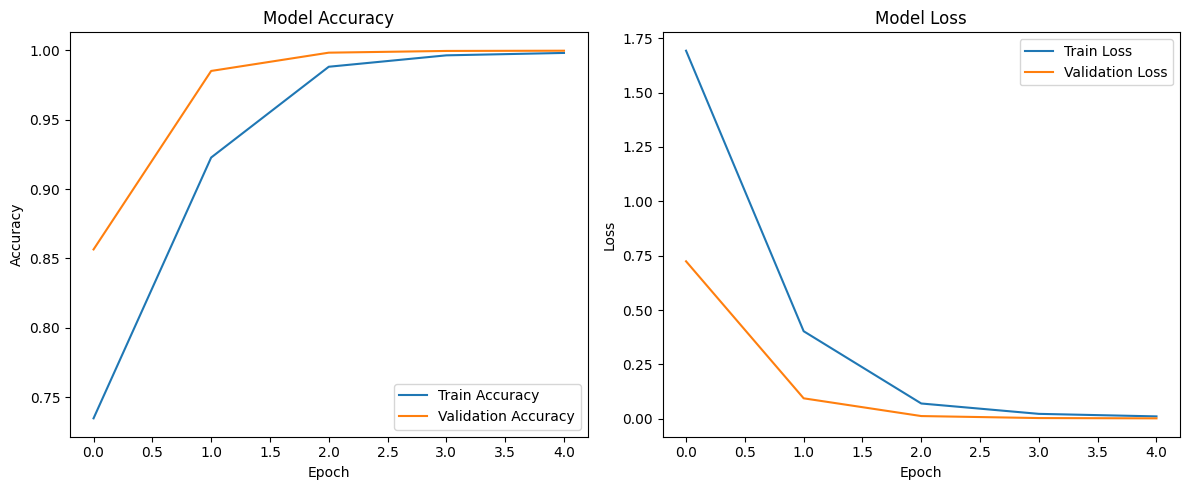

In [14]:
# Adjusted Hyperparameters
embed_dim = 256  # Reduced embedding dimension
num_heads = 4  # Fewer attention heads
ff_dim = 1024  # Reduced feedforward dimension
num_encoder_layers = 4  # Reduced encoder layers
num_decoder_layers = 4  # Reduced decoder layers
dropout_rate = 0.1  # Keep dropout constant
vocab_size = max_vocab_size + 1  # +1 for padding token
max_len = max_sequence_length  # Maximum sequence length
batch_size = 64  # Increased batch size if GPU memory allows
epochs = 5  # Fewer epochs
learning_rate = 1e-4  # Keep learning rate constant

# Build and Compile Model
transformer = build_transformer(
    vocab_size, embed_dim, num_heads, ff_dim, max_len, num_encoder_layers, num_decoder_layers, dropout_rate
)
transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
transformer.summary()

# Shift Target Sequences for Decoder Input and Output
y_train_in = X_train[:, :-1]  # Decoder input
y_train_out = X_train[:, 1:]  # Expected output
y_val_in = X_val[:, :-1]  # Validation decoder input
y_val_out = X_val[:, 1:]  # Validation expected output

# Create Dataset Pipelines
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train, y_train_in), y_train_out)).batch(batch_size).shuffle(10000)
val_dataset = tf.data.Dataset.from_tensor_slices(((X_val, y_val_in), y_val_out)).batch(batch_size)

# Train the Transformer
history = transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1
)

# Evaluate the Model on Test Set
y_test_in = X_test[:, :-1]
y_test_out = X_test[:, 1:]
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test, y_test_in), y_test_out)).batch(batch_size)
test_loss, test_accuracy = transformer.evaluate(test_dataset, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot Accuracy and Loss Evolution
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **6. Lyrics Generation:**

This code segment is used for generating lyrics in multiple languages (English, French, Arabic) and evaluating the generated text using the BLEU score metric. Here's a breakdown of each function and process:

**1. get_seed_lyrics Function:**

_Purpose:_ This function retrieves a random seed lyric from the Genius dataset for a specific language.

_Steps:_

- Filters the dataset based on the specified language.

- Randomly selects a lyric (using sample(n=1)).

- Tokenizes the lyric using a tokenizer and truncates it to the maximum length (max_len) if necessary.

- Returns: The seed lyric text, potentially truncated.

**2. generate_text Function:**

_Purpose:_ This function generates the next num_words words based on the seed text using a Transformer model.

_Steps:_

- The seed text is tokenized and padded to fit the model's input requirements.

- Creates an initial decoder input with the start-of-sequence token (<sos>).

- Uses the Transformer model to predict the next word, which is then appended to the generated text.

- Stops prediction if the end-of-sequence token (<eos>) is generated.

- Returns: The generated text, which consists of the seed text followed by the predicted sequence of words.

**3. compute_bleu Function:**

_Purpose:_ Calculates the BLEU score, a metric used to evaluate the quality of the generated text by comparing it to a reference (actual dataset continuation).

_Steps:_

- Tokenizes both the reference and the predicted text.

- Uses a smoothing function to handle small n-grams.

- Computes the BLEU score using the sentence_bleu function.

- Returns: The BLEU score, which measures how similar the generated text is to the reference.

**4. Generating Lyrics and Evaluating:**

The code iterates over a list of supported languages (en, fr, ar).

_For each language:_

- Retrieves a random seed lyric using the get_seed_lyrics function.

- Generates the next 50 words using the generate_text function.

- Computes the BLEU score by comparing the generated text to a reference continuation from the dataset.

_Outputs:_

- Displays the seed text and the generated lyrics for each language.

- Prints the BLEU score for each language, indicating the quality of the generated lyrics.

- Key Steps in the Workflow:

- Get a random seed lyric in a specific language.

- Predict the next words using the Transformer model.

- Compute the BLEU score to evaluate the quality of the generated lyrics.

- Repeat the process for different languages and display results.

In [15]:
# Define BLEU score computation
def compute_bleu(reference, hypothesis, tokenizer):
    """
    Compute the BLEU score for the generated lyrics.
    Args:
        reference (str): Original seed text.
        hypothesis (str): Generated text by the model.
        tokenizer: Language-specific tokenizer.
    Returns:
        float: BLEU score.
    """
    reference_tokens = [tokenizer.texts_to_sequences([reference])[0]]
    hypothesis_tokens = tokenizer.texts_to_sequences([hypothesis])[0]
    smooth_fn = SmoothingFunction().method1  # Apply smoothing for small n-grams
    return sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smooth_fn)

# Get seed lyrics
def get_seed_lyrics(dataset, tokenizer, language, max_len=50):
    """
    Get a random seed lyric from the dataset for the specified language.
    Args:
        dataset: The lyrics dataset.
        tokenizer: Language-specific tokenizer.
        language: Target language ('en', 'fr', 'ar').
        max_len: Maximum length for tokenized seed text.
    Returns:
        str: Seed text (truncated to max_len if necessary).
    """
    # Filter dataset for the specified language
    language_data = dataset[dataset['language'] == language]
    random_row = language_data.sample(n=1)
    seed_text = random_row['cleaned_lyrics'].values[0]

    # Tokenize and truncate to max_len
    tokenized_text = tokenizer.texts_to_sequences([seed_text])[0]
    if len(tokenized_text) > max_len:
        tokenized_text = tokenized_text[:max_len]
    seed_text = " ".join([tokenizer.index_word.get(idx, "<OOV>") for idx in tokenized_text])

    return f"<sos> {seed_text}"

# Generate text with strict greedy decoding
def generate_text(transformer_model, tokenizer, seed_text, max_len=50):
    """
    Generate lyrics using the Transformer model and return the generated text with strict greedy decoding.
    Args:
        transformer_model: Trained Transformer model.
        tokenizer: Tokenizer object for word-to-index mapping.
        seed_text: Initial text to start generation.
        max_len: Maximum length of the generated sequence.
    Returns:
        str: Generated text.
    """
    # Tokenize and pad the seed text
    input_seq = tokenizer.texts_to_sequences([seed_text])[0]
    input_seq = pad_sequences([input_seq], maxlen=max_len, padding="post")

    # Initialize the target sequence
    target_seq = np.zeros((1, max_len), dtype=np.int32)
    target_seq[0, 0] = tokenizer.word_index.get("<sos>", 1)  # <sos> token to start generation

    generated_text = []

    for i in range(1, max_len):
        # Predict the next token probabilities
        predictions = transformer_model.predict([input_seq, target_seq], verbose=0)[0, i - 1]

        # Perform greedy decoding (select the most probable next word)
        next_word_id = np.argmax(predictions)

        # Stop if <eos> token is predicted
        if next_word_id == tokenizer.word_index.get("<eos>", 0):
            break

        # Add the predicted word to the target sequence and generated text
        target_seq[0, i] = next_word_id
        generated_text.append(tokenizer.index_word.get(next_word_id, "<OOV>"))

    return " ".join(generated_text)

# Debugging improvements
def debug_generated_text(transformer_model, tokenizer, seed_text, max_len=50):
    """
    Debug the generation process by showing intermediate predictions and sequences.
    """
    print(f"Seed Text: {seed_text}")
    tokenized_seed = tokenizer.texts_to_sequences([seed_text])
    print(f"Tokenized Seed Text: {tokenized_seed}")
    padded_seed = pad_sequences(tokenized_seed, maxlen=max_len, padding="post")
    print(f"Padded Seed Text: {padded_seed}")

    generated_text = generate_text(transformer_model, tokenizer, seed_text, max_len)
    print(f"Generated Text: {generated_text}")
    return generated_text

# Example usage in the main loop
languages = ["en", "fr", "ar"]
for lang in languages:
    tokenizer = tokenizers[lang]  # Language-specific tokenizer
    seed_text = get_seed_lyrics(final_dataset, tokenizer, lang, max_len=50)

    print(f"\nGenerating lyrics in {lang.upper()}...")
    print(f"Seed text: {seed_text}\n")

    # Generate lyrics
    generated_lyrics = generate_text(transformer, tokenizer, seed_text, max_len=50)
    print(f"{lang.upper()} Lyrics:")
    print(generated_lyrics)

    # Compute BLEU score
    bleu_score = compute_bleu(seed_text, generated_lyrics, tokenizer)
    print(f"BLEU Score for {lang.upper()} lyrics: {bleu_score:.4f}")



Generating lyrics in EN...
Seed text: <sos> i know youre out in cabo hanging with your brother wishin that i was your bottle so i could be close to your lips again i know you didnt call your parents and tell em that we ended cause you know that theyd be offended did you not want to

EN Lyrics:
know youre out in cabo hanging with your brother wishin that i was your bottle so i could be close to your lips again i know you didnt call your parents and tell em that we ended cause you know that theyd be offended did you not want to
BLEU Score for EN lyrics: 0.9600

Generating lyrics in FR...
Seed text: <sos> jme couche à 9 heures de <OOV> un dernier joint de kush pour me ramener au lit ouh oui le sommeil ma zappé le destin dun vendeur de sable en caisse ou bien à pieds payemoi en pièces ou en papier les <OOV> le wari le cash sur la tête

FR Lyrics:
couche à 9 heures de <OOV> un dernier joint de kush pour me ramener au lit ouh oui le sommeil ma zappé le destin dun vendeur de sable en caisse 